# Investigating the enron dataset for fraud detection

## Project overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

>  Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? 

The goal of this project is to build a person of interest(POI) identifier based on financial and email data made public as a result of the Enron scandal. POI are the individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.
I have used machine learning techniques and algorithms to build a POI identifier.

In [1]:
import sys
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
%matplotlib inline



C:\Users\archa\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

The dataset includes Enron emails and financial data with a hand-generated list of persons of interest in the fraud case.
Let's look at all the features in the dataset.

In [3]:
features_list = ['poi','salary', 'fraction_from_poi','fraction_to_poi' ]

In [4]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )

#Convert the dictionary into a dataframe    
#df = pd.DataFrame.from_dict(data_dict, orient='index')
#df.replace('NaN', np.nan, inplace = True)

#df.info()

We can see that there are 21 different features. Let's look at the two important features, 'salary' and 'bonus'.

### Outliers in the data

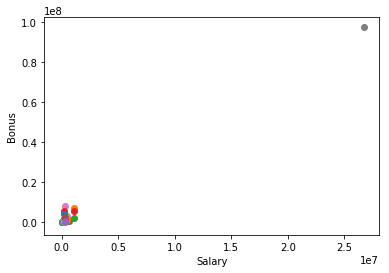

In [5]:
#df.plot.scatter(x = 'salary', y = 'bonus')
features = ["salary", "bonus"]

data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()


As we can see there one huge outlier in the plot whose salary is greater than 2.5 * $10^{7}$. Let's find out the employee with such huge salary.

In [6]:
#Convert the dictionary into a dataframe    
df = pd.DataFrame.from_dict(data_dict, orient='index')
df['salary'].idxmax()

'TOTAL'

The huge salary seems to be the total of all the salaries, hence the outlier. As this information is not required to detect the POI's, I'm going to remove this outlier from the dataframe.

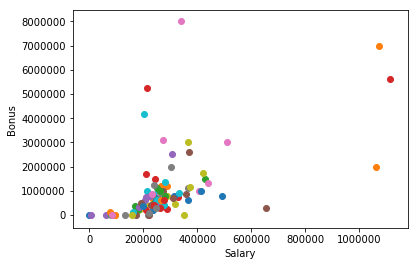

In [7]:
data_dict.pop('TOTAL',0)
data = featureFormat(data_dict, features)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

### Creating New Features

> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.

In the dataset, there are a number of emails sent to POI's and received from POI's. To check if an employee sends to or receives from POI's more in general, I'm creating these new features: 

**Fraction of emails from POI's to this person**

**Fraction of emails from this person to POI's**

In [8]:
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    ### beware of "NaN" when there is no known email address (and so
    ### no filled email features), and integer division!
    ### in case of poi_messages or all_messages having "NaN" value, return 0.
    if poi_messages == "NaN" or all_messages == "NaN" or poi_messages == 0 or all_messages == 0:
        return 0
    else:
        return (float(poi_messages)/float(all_messages))

for name in data_dict:
    from_poi_to_this_person = data_dict[name]["from_poi_to_this_person"]
    to_messages = data_dict[name]["to_messages"]
    from_this_person_to_poi = data_dict[name]["from_this_person_to_poi"]
    from_messages = data_dict[name]["from_messages"]
    
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    
    data_dict[name]["fraction_from_poi"] = fraction_from_poi
    data_dict[name]["fraction_to_poi"] = fraction_to_poi

In [9]:
my_dataset = data_dict

data = featureFormat(my_dataset, features_list)
print features_list

['poi', 'salary', 'fraction_from_poi', 'fraction_to_poi']


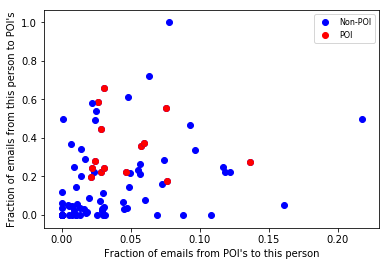

In [10]:
### plot new features
for point in data:
    from_poi = point[2]
    to_poi = point[3]
    non_poi = plt.scatter(from_poi, to_poi, color = 'b', label='non-poi' )
    if point[0] == 1:
        poi = plt.scatter(from_poi, to_poi, color="r", label='poi')
        
        
plt.xlabel("Fraction of emails from POI's to this person")
plt.ylabel("Fraction of emails from this person to POI's")
plt.legend((non_poi, poi),
           ('Non-POI', 'POI'),
           scatterpoints=1,
           fontsize=8)
plt.show()

### Feature Scaling

In [55]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi", "fraction_to_poi",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 
                 'expenses', 
                 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 
                 'restricted_stock', 
                 'director_fees',
                 #'from_poi_to_this_person',
                #'from_this_person_to_poi'
                ]

data = featureFormat(my_dataset, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.2,
                                                                                             random_state=42)


In [56]:
clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'Accuracy score for decision tree:', score

Accuracy score for decision tree: 0.758620689655


In [59]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
#print indices

print 'Feature importances: '
for i in range(len(indices)):
    print "{} {} : {}".format(i+1,features_list[i+1],importances[indices[i]])

Feature importances: 
1 salary : 0.299208144796
2 bonus : 0.200246444732
3 fraction_from_poi : 0.148498560263
4 fraction_to_poi : 0.102644425667
5 deferral_payments : 0.093954248366
6 total_payments : 0.0578179989945
7 loan_advances : 0.0578179989945
8 restricted_stock_deferred : 0.0398121781869
9 deferred_income : 0.0
10 total_stock_value : 0.0
11 expenses : 0.0
12 exercised_stock_options : 0.0
13 long_term_incentive : 0.0
14 shared_receipt_with_poi : 0.0
15 restricted_stock : 0.0
16 director_fees : 0.0


Based on the decision tree feature selection, I chose the following 8 features:

['salary', 'bonus', 'fraction_from_poi', 'fraction_to_poi', 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred']